Arquivo corrigido salvo em: /home/junior/Documents/SpatialPreferential/network/N_500/dim_2/alpha_a_2.00_alpha_g_2.00/gml/gml_998763285_corrigido.gml


,hub,site,distance
0,0,1,7.495079
1,0,3,1.592788
2,0,4,3.928808
3,0,5,1.679912
4,0,7,1.804849
...,...,...,...
70,3,281,5.476026
71,3,308,1.020777
72,3,342,0.219619
73,3,393,0.550969


/home/junior/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/tmp/ipykernel_40941/4037840050.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


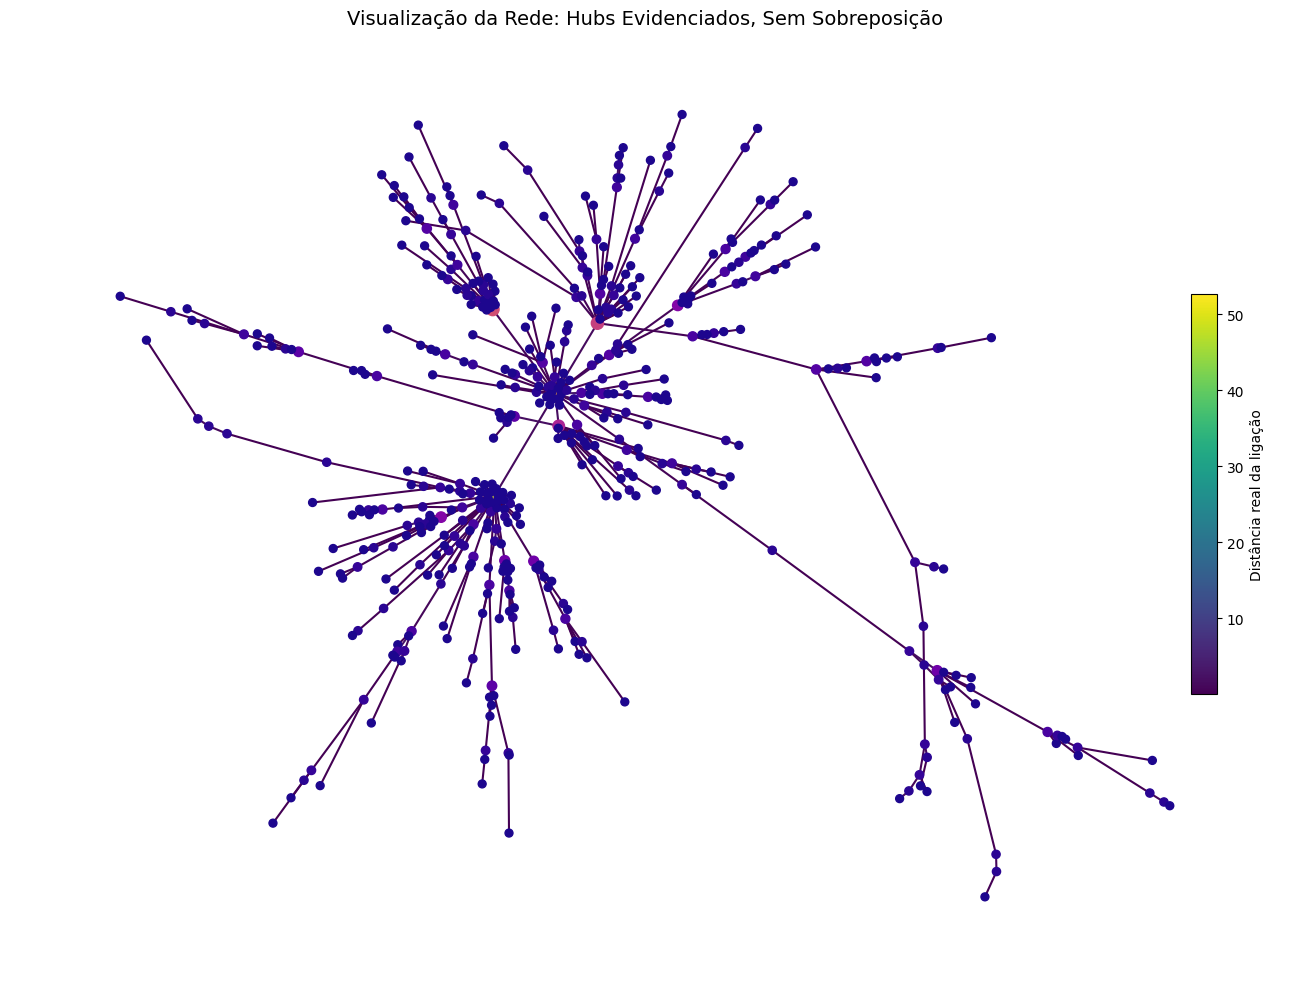

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import gzip
import matplotlib.patches as patches
# Caminho de entrada e saída
input_path = "/home/junior/Documents/SpatialPreferential/network/N_500/dim_2/alpha_a_2.00_alpha_g_2.00/gml/gml_998763285.gml.gz"
output_path = input_path.replace(".gml", "_corrigido.gml").replace(".gz", "")

# Corrigir as linhas com "(x)" para apenas "x"
with gzip.open(input_path, "rt", encoding="utf-8", errors="ignore") as f_in, open(output_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        line_corrigida = line.replace("(", "").replace(")", "")
        f_out.write(line_corrigida)

print(f"Arquivo corrigido salvo em: {output_path}")

# Caminho original (usado apenas como valor de referência)
gml_path = "/home/junior/Documents/SpatialPreferential/network/N_500/dim_2/alpha_a_2.00_alpha_g_2.00/gml/gml_998763285_corrigido.gml"

# Carrega a rede (substitua o caminho abaixo por gml_path se estiver executando localmente)
G = nx.read_gml(gml_path)
# Exemplo: considerar hubs os nós com grau > 90% do grau máximo
# Suponha que 'hubs' é uma lista com os índices dos nós mais conectados



# Calcula o grau dos nós
degrees = dict(G.degree())
max_deg = max(degrees.values())
norm_deg = {n: degrees[n] / max_deg for n in G.nodes()}

# Tamanhos e cores dos nós proporcionais ao grau
node_sizes = [30 + 100 * norm_deg[n] for n in G.nodes()]
node_colors = [cm.plasma(norm_deg[n]) for n in G.nodes()]

# Distâncias nas arestas
distances = []
for u, v in G.edges():
    dist = G[u][v].get("distance", 1.0)
    G[u][v]["distance"] = dist
    distances.append(dist)

distances = np.array(distances)
norm = Normalize(vmin=distances.min(), vmax=distances.max())
edge_colors = [cm.viridis(norm(G[u][v]["distance"])) for u, v in G.edges()]

def clustered_star_layout(G, hubs, spacing=4.0, radius=1.5):
    """
    Coloca hubs afastados em um grid e vizinhos em estrelas ao redor de cada hub.
    """
    pos = {}
    n_hubs = len(hubs)
    grid_cols = int(np.ceil(np.sqrt(n_hubs)))

    for idx, hub in enumerate(hubs):
        row = idx // grid_cols
        col = idx % grid_cols

        center_x = col * spacing
        center_y = -row * spacing  # usar negativo para evitar sobreposição
        pos[hub] = np.array([center_x, center_y])

        neighbors = list(G.neighbors(hub))
        angle_step = 2 * np.pi / len(neighbors) if neighbors else 1

        for i, neighbor in enumerate(neighbors):
            if neighbor in hubs:
                continue  # não sobrepor outros hubs
            angle = i * angle_step
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            pos[neighbor] = np.array([x, y])

    # Para nós isolados ou não incluídos (caso de hubs entre si)
    for node in G.nodes():
        if node not in pos:
            pos[node] = np.random.rand(2) * spacing * n_hubs  # joga longe, para não sobrepor

    return pos


# Define limiar para considerar um nó como hub

hubs = [n for n, d in G.degree() if d >= 0.7*max(dict(G.degree()).values())]
# Lista para armazenar conexões dos hubs
hub_links = []

# Percorre todas as arestas
for u, v, data in G.edges(data=True):
    if u in hubs or v in hubs:
        hub_links.append({
            "hub": u if u in hubs else v,
            "site": v if u in hubs else u,
            "distance": data.get("distance", None)
        })

# Cria o DataFrame
df_hub_links = pd.DataFrame(hub_links)

# Exibe
display(df_hub_links)

# Layout com boa separação dos hubs
#pos = nx.spring_layout(G, seed=42, k=1.5, iterations=300)
pos = nx.spring_layout(
    G,
    k=8.0,  # distância ideal entre os nós
    iterations=1000,
    weight='distance',  # usa pesos se existir
    seed=42
)


# Plotagem
fig, ax = plt.subplots(figsize=(13, 10))

# Nós
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=cm.plasma,
    ax=ax
)

# Arestas
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    edge_cmap=cm.viridis,
    width=1.5,
    ax=ax
)

# Título e configuração
ax.set_title("Visualização da Rede: Hubs Evidenciados, Sem Sobreposição", fontsize=14)
plt.axis("off")

# Barra de cores das arestas
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = ColorbarBase(cax, cmap=cm.viridis, norm=norm)
cb.set_label("Distância real da ligação", fontsize=10)

plt.tight_layout()

# # === DESTACAR conexões entre hubs com contorno ===
# # Lista de hubs
# hubs = [n for n, d in G.degree() if d >= 0.7 * max(dict(G.degree()).values())]

# # Lista de pares conectados entre hubs
# hub_connections = []

# # Percorre todos os pares únicos de hubs
# for i in range(len(hubs)):
#     for j in range(i + 1, len(hubs)):
#         u, v = hubs[i], hubs[j]
#         if G.has_edge(u, v):
#             dist = G[u][v].get("distance", None)
#             hub_connections.append({
#                 "hub1": u,
#                 "hub2": v,
#                 "connected": True,
#                 "distance": dist
#             })
#         else:
#             hub_connections.append({
#                 "hub1": u,
#                 "hub2": v,
#                 "connected": False,
#                 "distance": None
#             })

# # Converte para DataFrame
# df_hub_connections = pd.DataFrame(hub_connections)
# hub_pairs = [(row["hub1"], row["hub2"]) for _, row in df_hub_connections.iterrows() if row["connected"]]


# # Percorre pares de hubs conectados
# # Percorre pares de hubs conectados
# for _, row in df_hub_connections.iterrows():
#     if row["connected"]:
#         u, v = row["hub1"], row["hub2"]
#         x1, y1 = pos[u]
#         x2, y2 = pos[v]
        
#         # Cálculo do centro e tamanho da elipse de contorno
#         xc, yc = (x1 + x2) / 2, (y1 + y2) / 2
#         width = np.linalg.norm([x2 - x1, y2 - y1]) * 1.2  # um pouco maior
#         height = 0.12 * width  # mais visível

#         angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

#         # Elipse de sombra (mais larga, cinza claro)
#         shadow = patches.Ellipse(
#             (xc, yc), width, height, angle=angle,
#             edgecolor='lightgray', facecolor='none',
#             linewidth=6, linestyle='solid', zorder=3
#         )
#         ax.add_patch(shadow)

#         # Elipse principal (preta, mais fina)
#         ellipse = patches.Ellipse(
#             (xc, yc), width, height, angle=angle,
#             edgecolor='black', facecolor='none',
#             linewidth=2.5, linestyle='solid', zorder=4
#         )
#         ax.add_patch(ellipse)


plt.show()


In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import gzip

# Caminho de entrada e saída
input_path = "/home/junior/Documents/SpatialPreferential/network/N_40000/dim_2/alpha_a_2.00_alpha_g_4.00/gml/gml_456472383.gml.gz"
output_path = input_path.replace(".gml", "_corrigido.gml").replace(".gz", "")

# Corrigir as linhas com "(x)" para apenas "x"
with gzip.open(input_path, "rt", encoding="utf-8", errors="ignore") as f_in, open(output_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        line_corrigida = line.replace("(", "").replace(")", "")
        f_out.write(line_corrigida)

print(f"Arquivo corrigido salvo em: {output_path}")

# Caminho original (usado apenas como valor de referência)
gml_path = "/home/junior/Documents/SpatialPreferential/network/N_40000/dim_2/alpha_a_2.00_alpha_g_4.00/gml/gml_456472383_corrigido.gml"

# Carrega a rede (substitua o caminho abaixo por gml_path se estiver executando localmente)
G = nx.read_gml(gml_path)
# Exemplo: considerar hubs os nós com grau > 90% do grau máximo
# Suponha que 'hubs' é uma lista com os índices dos nós mais conectados



# Calcula o grau dos nós
degrees = dict(G.degree())
max_deg = max(degrees.values())
norm_deg = {n: degrees[n] / max_deg for n in G.nodes()}

# Tamanhos e cores dos nós proporcionais ao grau
node_sizes = [30 + 100 * norm_deg[n] for n in G.nodes()]
node_colors = [cm.plasma(norm_deg[n]) for n in G.nodes()]

# Distâncias nas arestas
distances = []
for u, v in G.edges():
    dist = G[u][v].get("distance", 1.0)
    G[u][v]["distance"] = dist
    distances.append(dist)

distances = np.array(distances)
norm = Normalize(vmin=distances.min(), vmax=distances.max())
edge_colors = [cm.viridis(norm(G[u][v]["distance"])) for u, v in G.edges()]



# Define limiar para considerar um nó como hub

hubs = [n for n, d in G.degree() if d >= 0.8*max(dict(G.degree()).values())]
# Lista para armazenar conexões dos hubs
hub_links = []

# Percorre todas as arestas
for u, v, data in G.edges(data=True):
    if u in hubs or v in hubs:
        hub_links.append({
            "hub": u if u in hubs else v,
            "site": v if u in hubs else u,
            "distance": data.get("distance", None)
        })

# Cria o DataFrame
df_hub_links = pd.DataFrame(hub_links)
hubs_v = df_hub_links["hub"].unique()
hubs_v


Arquivo corrigido salvo em: /home/junior/Documents/SpatialPreferential/network/N_40000/dim_2/alpha_a_2.00_alpha_g_4.00/gml/gml_456472383_corrigido.gml


array([ 2, 12, 22,  8])

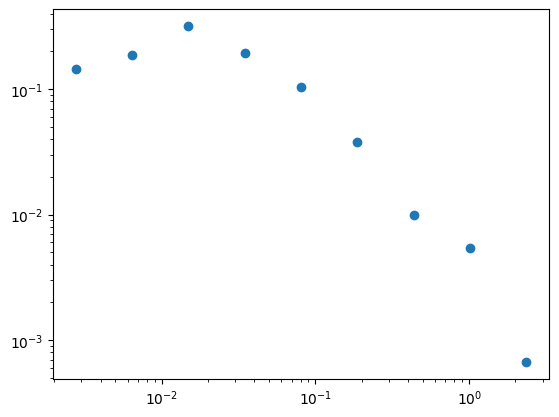

In [51]:
n_bins = 10
# for h in hubs_v:
#     bins = np.logspace(np.log10(min(df_hub_links[df_hub_links["hub"]==h]["distance"])), np.log10(max(df_hub_links[df_hub_links["hub"]==h]["distance"])), n_bins)
#     pdf, bin_edges = np.histogram(df_hub_links[df_hub_links["hub"]==h]["distance"], bins = bins, density = True)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     bin_widhs = bin_edges[1:] - bin_edges[:-1]
#     pdf = np.array(pdf) / sum(pdf)
#     plt.plot(bin_widhs, pdf, 'o')

bins = np.logspace(np.log10(min(df_hub_links[df_hub_links["hub"]==hubs_v[1]]["distance"])), np.log10(max(df_hub_links[df_hub_links["hub"]==hubs_v[1]]["distance"])), n_bins)
pdf, bin_edges = np.histogram(df_hub_links[df_hub_links["hub"]==hubs_v[1]]["distance"], bins = bins, density = True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_widhs = bin_edges[1:] - bin_edges[:-1]
pdf = np.array(pdf) / sum(pdf)
plt.plot(bin_widhs, pdf, 'o')
plt.xscale("log")
plt.yscale("log")
#plt.show()

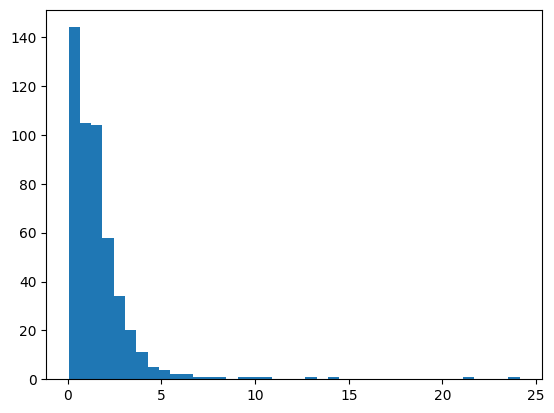

In [72]:
# Caminho original (usado apenas como valor de referência)
gml_path = "/home/junior/Documents/SpatialPreferential/network/N_500/dim_3/alpha_a_2.00_alpha_g_2.00/gml/gml_1413284977_corrigido.gml"

# Carrega a rede (substitua o caminho abaixo por gml_path se estiver executando localmente)
G = nx.read_gml(gml_path)

# Calcula o grau dos nós
degrees = dict(G.degree())
max_deg = max(degrees.values())
norm_deg = {n: degrees[n] / max_deg for n in G.nodes()}

# Tamanhos e cores dos nós proporcionais ao grau
node_sizes = [30 + 100 * norm_deg[n] for n in G.nodes()]
node_colors = [cm.plasma(norm_deg[n]) for n in G.nodes()]

# Distâncias nas arestas
distances = []
for u, v in G.edges():
    dist = G[u][v].get("distance", 1.0)
    G[u][v]["distance"] = dist
    distances.append(dist)
plt.hist(distances, bins=40)
plt.show()


Arquivo corrigido salvo em: /home/junior/Documents/SpatialPreferential/network/N_1000/dim_2/alpha_a_3.00_alpha_g_2.00/gml/gml_300254478_corrigido.gml
